In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import zipfile
from datetime import datetime

#%matplotlib inline

### Importar e tratar os dados LOCAIS

In [ ]:
# lista arquivos por formato
def filtrar_arquivo(tipo):
    path = './'
    lst_arq = os.listdir(path) # listando novamente o diretório para verificar arquivos csv
    return [arq for arq in lst_arq if arq[-3:] == tipo]

# Separa arquivo zip caso haja outros tipos de arquivo na pasta
lst_zip = filtrar_arquivo('zip')

# extrair arquivos do zip para trabalhar
for zp in lst_zip:
    fzp = zipfile.ZipFile(zp)
    fzp.extractall('./') 
    fzp.close()

### Importar e tratar os dados no GOOGLE COLAB

In [ ]:
#  montar google driver
from google.colab import drive
drive.mount('/content/drive/')

# extrai do Zip os csv's
fzp = zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset.zip')
fzp.extractall('.') 
fzp.close()

In [ ]:
# dog = 0
# cat = 1
class_name = ['dog','cat']

dir_img_train = 'dataset/train/*.jpg'
dir_img_test = 'dataset/test/*.jpg'

In [ ]:
def convert_img_array(lst):
    """
    lista diretorios com imagens e convertem array
    
    """
    lst_img, lst_label=[],[]
    for d in glob(lst):
        lst_img.append(cv2.imread(d))
        if 'dog' in d:
            lst_label.append('0')
        elif 'cat' in d:
            lst_label.append('1')
    return np.array(lst_img), np.array(lst_label)

In [ ]:
# gerando dados de trainos e test
train_img, train_label = convert_img_array(dir_img_train)
test_img, test_label = convert_img_array(dir_img_test)

In [8]:
train_img.shape

(8000, 32, 32, 3)

In [9]:
test_label.shape

(2000,)

In [10]:
train_img.shape

(8000, 32, 32, 3)

In [11]:
train_label.shape

(8000,)

In [ ]:
# escalar as imagens para que o valor esteja entre 0 e 1
train_img = train_img / 255.0
test_img = test_img / 255.0

### Classificação com Keras

Melhor acurácia utilizando optimizer('sgd') = 0.7505

In [13]:
# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau


print(tf.__version__)


#!pip install -U --ignore-installed tensorboardcolab

1.14.0


In [14]:
# criar o modelo
#model = keras.Sequential([
#    keras.layers.Flatten(input_shape = (32, 32, 3)),
#    keras.layers.Dense(128, activation = tf.nn.relu),
#    keras.layers.Dense(128, activation = tf.nn.relu),
#    keras.layers.Dense(128, activation = tf.nn.relu),
#    keras.layers.Dense(2, activation = tf.nn.softmax)
#])

# Estaciar Modelo
model = Sequential()

# Camada de Convolução
model.add(Conv2D(32,(5,5),padding='same', input_shape = (32, 32, 3), activation=tf.nn.relu))
model.add(Conv2D(64,(5,5),padding='same', activation=tf.nn.relu))

# Camada de Polling
model.add(MaxPooling2D(pool_size=(2,2)))

# camada de Dropout
model.add(Dropout(0,25))

# Flattening
model.add(Flatten())

# Full conection
model.add(Dense(512, activation = tf.nn.relu))

# camada de Dropout
model.add(Dropout(0.5))

model.add(Dense(2, activation = tf.nn.softmax))

W0826 16:15:57.690465 139909430085504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model.summary()

# compilar modelo
model.compile(optimizer='sgd', 
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy']
             )

In [17]:
# treinar modelo
start = datetime.now()



learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
earlystop = EarlyStopping(patience=10)
callbacks = [learning_rate_reduction, earlystop]


treino = model.fit(train_img, 
          train_label,
          batch_size = 32,
          epochs = 1000,
          validation_split=0.2,
          verbose = 1,
          callbacks=callbacks)


print('')
print('Tempo decorrido para treinar o modelo: ', datetime.now() - start)

Train on 6400 samples, validate on 1600 samples
Epoch 1/1000
6400/6400 [==============================] - 5s 795us/sample - loss: 0.6900 - acc: 0.5302 - val_loss: 0.6807 - val_acc: 0.5700
Epoch 2/1000
6400/6400 [==============================] - 1s 220us/sample - loss: 0.6780 - acc: 0.5775 - val_loss: 0.6825 - val_acc: 0.5344
Epoch 3/1000
6400/6400 [==============================] - 1s 206us/sample - loss: 0.6682 - acc: 0.6005 - val_loss: 0.6623 - val_acc: 0.6037
Epoch 4/1000
6400/6400 [==============================] - 1s 208us/sample - loss: 0.6586 - acc: 0.6092 - val_loss: 0.6664 - val_acc: 0.5744
Epoch 5/1000
6400/6400 [==============================] - 1s 209us/sample - loss: 0.6428 - acc: 0.6361 - val_loss: 0.6403 - val_acc: 0.6256
Epoch 6/1000
6400/6400 [==============================] - 1s 209us/sample - loss: 0.6291 - acc: 0.6497 - val_loss: 0.6379 - val_acc: 0.6338
Epoch 7/1000
6400/6400 [==============================] - 1s 210us/sample - loss: 0.6166 - acc: 0.6647 - val_los

In [18]:
# Eficiência do modelo
test_loss, test_acc = model.evaluate(test_img, test_label)
print('Acurácia:', test_acc)
print('Perda:', test_loss)

2000/2000 [==============================] - 0s 124us/sample - loss: 0.6178 - acc: 0.7505
Acurácia: 0.7505
Perda: 0.6178004508018493


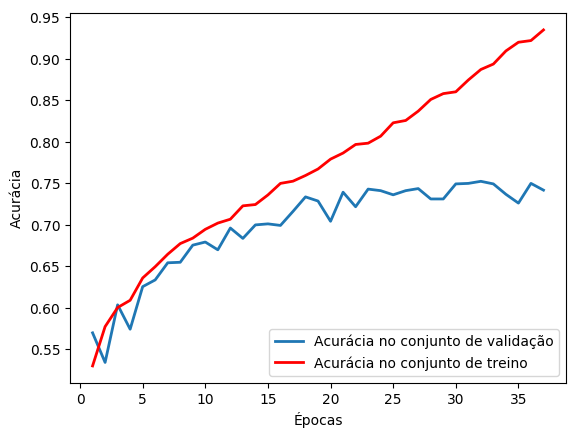

In [19]:
history_dict = treino.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
range_epochs = range(1, len(acc) + 1)


plt.style.use('default')
accuracy_val = plt.plot(range_epochs, val_acc, label='Acurácia no conjunto de validação')
accuracy_train = plt.plot(range_epochs, acc, label='Acurácia no conjunto de treino', color="r")
plt.setp(accuracy_val, linewidth=2.0)
plt.setp(accuracy_train, linewidth=2.0)
plt.xlabel('Épocas') 
plt.ylabel('Acurácia')
plt.legend(loc="lower right")

plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


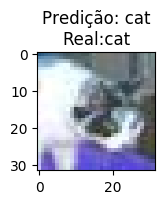

In [21]:
# previsoes
predict = model.predict_classes(test_img)

plt.figure(figsize=(7,14))

random_num = np.random.randint(0, len(test_img))
img = test_img[random_num]

plt.subplot(6,4,1)

p=predict[random_num]
predito =  str(class_name[p])
real = str(class_name[int(test_label[p])])

plt.subplot(6,4,1)
plt.margins(x = 20, y = 20)
plt.title('Predição: ' + predito + '\n'+ 'Real:'+ real)
plt.imshow(img.reshape(32, 32,3), cmap=plt.get_cmap('gray'));

plt.show()



### Classificação com Machine Learning





In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# padroniza a entrada com esse reshape
# convert de 3d para 2d
def _reshape(ds):
    return ds.reshape(len(ds),-1)

In [ ]:
x_train = _reshape(train_img)
y_test = _reshape(test_img)

#### Modelo SVM 

Melhor acurácia = 0.62

In [ ]:
from sklearn.svm import SVC

In [ ]:
# accuracy testada do modelo
# 'linear' =  0.5935
# 'poly' = 0.566
# 'rbf' = 0.6195
# 'sigmoid' = 0.5885

model_svm = SVC(kernel='rbf')
model_svm.fit(x_train, train_label)

predicted = model_svm.predict(y_test)
accuracy_score(test_label, predicted)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6195

#### Regressão Logistica

Melhor acurácia = 0.597 com 'sag'

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_log = LogisticRegression(solver='sag')

In [ ]:
model_log.fit(x_train, train_label)
pred_log1 = model_log.predict(y_test)
accuracy_score(test_label, pred_log1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.597

#### Floresta aleatória (Random Florest)

Melhor acurácia = 0.575

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_rd = RandomForestClassifier()

In [ ]:
model_rd.fit(x_train, train_label)
pred_rd = model_rd.predict(y_test)
accuracy_score(test_label, pred_rd)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.575

#### Naives Bayes

Melhor acurácia = 0.575

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model_nb = GaussianNB()

In [ ]:
model_nb.fit(x_train, train_label)
pred_nb = model_rd.predict(y_test)
accuracy_score(test_label, pred_nb)

0.575

#### K-Nearest Neighbors (KNN)

Melhor acurácia = 0.582

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model_knn = KNeighborsClassifier()

In [ ]:
model_knn.fit(x_train, train_label)
pred_knn = model_knn.predict(y_test)
accuracy_score(test_label, pred_knn)

0.5825